**Import all you can!**

In [21]:
import numpy as numpy
import matplotlib.pyplot as plt
import scipy as sp
from matplotlib.pyplot import *
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
from torchvision import transforms
from torchvision import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from functools import partial
from dataclasses import dataclass
from collections import OrderedDict
import os
from PIL import Image
import torchvision.transforms.functional as TF
import time
from sklearn.svm import SVC
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_auc_score
cuda = torch.cuda.is_available()
from torch.autograd import Variable
from torchvision.utils import save_image# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cuda
!pip install torchsummary
from torchsummary import summary
import matplotlib.animation as animation
from IPython.display import HTML
import torchvision.utils as vutils

In [2]:
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
#! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
#! chmod 600 ~/.kaggle/kaggle.json
#! kaggle datasets list
#! pip install --upgrade --force-reinstall --no-deps kaggle

Saving kaggle.json to kaggle.json


In [3]:
! kaggle competitions download -c yash612/covidnet-mini-and-gan-enerated-chest-xray
! kaggle datasets download -d yash612/covidnet-mini-and-gan-enerated-chest-xray
! unzip covidnet-mini-and-gan-enerated-chest-xray.zip -d data

Streaming output truncated to the last 5000 lines.
  inflating: data/chest_xray/chest_xray/train/NORMAL/normal-xray204.jpeg  
  inflating: data/chest_xray/chest_xray/train/NORMAL/normal-xray205.jpeg  
  inflating: data/chest_xray/chest_xray/train/NORMAL/normal-xray206.jpeg  
  inflating: data/chest_xray/chest_xray/train/NORMAL/normal-xray207.jpeg  
  inflating: data/chest_xray/chest_xray/train/NORMAL/normal-xray208.jpeg  
  inflating: data/chest_xray/chest_xray/train/NORMAL/normal-xray209.jpeg  
  inflating: data/chest_xray/chest_xray/train/NORMAL/normal-xray21.jpeg  
  inflating: data/chest_xray/chest_xray/train/NORMAL/normal-xray210.jpeg  
  inflating: data/chest_xray/chest_xray/train/NORMAL/normal-xray211.jpeg  
  inflating: data/chest_xray/chest_xray/train/NORMAL/normal-xray212.jpeg  
  inflating: data/chest_xray/chest_xray/train/NORMAL/normal-xray213.jpeg  
  inflating: data/chest_xray/chest_xray/train/NORMAL/normal-xray214.jpeg  
  inflating: data/chest_xray/chest_xray/train/NORM

**Hyperparameters**

In [7]:
# # Root directory for dataset
# dataroot = "data/celeba"

# Number of workers for dataloader
num_workers = 4

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 25

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

- dataroot - the path to the root of the dataset folder. We will talk more about the dataset in the next section
- workers - the number of worker threads for loading the data with the DataLoader
- batch_size - the batch size used in training. The DCGAN paper uses a batch size of 128
- image_size - the spatial size of the images used for training. This implementation defaults to 64x64. If another size is desired, the structures of D and G must be changed. See here for more details
- nc - number of color channels in the input images. For color images this is 3
- nz - length of latent vector
- ngf - relates to the depth of feature maps carried through the generator
- ndf - sets the depth of feature maps propagated through the discriminator
num_epochs - number of training epochs to run. Training for longer will probably lead to better results but will also take much longer
- lr - learning rate for training. As described in the DCGAN paper, this number should be 0.0002
- beta1 - beta1 hyperparameter for Adam optimizers. As described in paper, this number should be 0.5
- ngpu - number of GPUs available. If this is 0, code will run in CPU mode. If this number is greater than 0 it will run on that number of GPUs

**Apply transformation on the images**

In [8]:
trans_apply=transforms.Compose([transforms.Resize((image_size,image_size)),transforms.ToTensor(),transforms.Normalize((0, 0, 0), (0.5, 0.5, 0.5))])
train_dataset=datasets.ImageFolder('data/chest_xray/chest_xray/train',transform=trans_apply)
val_dataset=datasets.ImageFolder('data/chest_xray/chest_xray/val',transform=trans_apply)
test_dataset=datasets.ImageFolder('data/chest_xray/chest_xray/test',transform=trans_apply)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 64, 64])
3


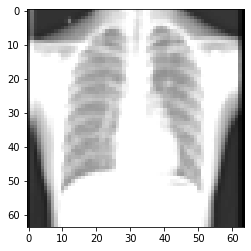

In [9]:
plt.imshow(np.transpose(test_dataset[100][0],axes=(1,2,0)))
print(train_dataset[1600][0].shape)
print(len(train_dataset.classes))
n_classes=len(train_dataset.classes)

In [10]:
print("train",train_dataset.__len__(), len(train_dataset.classes))
print("val",val_dataset.__len__(), len(val_dataset.classes))
print("test",test_dataset.__len__(), len(test_dataset.classes))

train 5882 3
val 27 3
test 635 3


In [11]:
from __future__ import print_function
import argparse
import h5py
import numpy as np
import os
import time
import torch
import torch.utils.data
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.dataset import Dataset
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import make_grid , save_image
import torchvision.utils as vutils

**Data Loader**

In [12]:
# num_workers = 4 if cuda else 0 
    
# Training data
train_loader_args = dict(shuffle=True, batch_size=100, num_workers=num_workers) if cuda\
                    else dict(shuffle=True, batch_size=800)
train_loader = data.DataLoader(train_dataset, **train_loader_args)

# Validation data
val_loader_args = dict(shuffle=True, batch_size=10, num_workers=num_workers) if cuda\
                    else dict(shuffle=True, batch_size=500)
val_loader = data.DataLoader(val_dataset, **val_loader_args)

# Testing data
test_loader_args = dict(shuffle=False, num_workers=num_workers) if cuda\
                    else dict(shuffle=False,drop_last=True)
test_loader = data.DataLoader(test_dataset, **test_loader_args)


In [13]:
data, _ = next(iter(train_loader))
print (data.size())
print (data[1, :])
#show_and_save("gen" ,make_grid((data*0.5+0.5).cpu(),8))

torch.Size([100, 3, 64, 64])
tensor([[[0.5255, 0.3216, 0.2667,  ..., 0.2588, 0.2588, 0.3137],
         [0.5176, 0.3216, 0.2667,  ..., 0.2588, 0.2588, 0.3137],
         [0.5176, 0.3216, 0.2667,  ..., 0.2588, 0.2588, 0.3137],
         ...,
         [0.5961, 0.7373, 0.8784,  ..., 0.8157, 0.7137, 0.6902],
         [0.5647, 0.7294, 0.8784,  ..., 0.8078, 0.7059, 0.6902],
         [0.5569, 0.7294, 0.8863,  ..., 0.8078, 0.6902, 0.6824]],

        [[0.5255, 0.3216, 0.2667,  ..., 0.2588, 0.2588, 0.3137],
         [0.5176, 0.3216, 0.2667,  ..., 0.2588, 0.2588, 0.3137],
         [0.5176, 0.3216, 0.2667,  ..., 0.2588, 0.2588, 0.3137],
         ...,
         [0.5961, 0.7373, 0.8784,  ..., 0.8157, 0.7137, 0.6902],
         [0.5647, 0.7294, 0.8784,  ..., 0.8078, 0.7059, 0.6902],
         [0.5569, 0.7294, 0.8863,  ..., 0.8078, 0.6902, 0.6824]],

        [[0.5255, 0.3216, 0.2667,  ..., 0.2588, 0.2588, 0.3137],
         [0.5176, 0.3216, 0.2667,  ..., 0.2588, 0.2588, 0.3137],
         [0.5176, 0.3216, 0.2

In [45]:
# encoder block (used in encoder and discriminator)
class EncoderBlock(nn.Module):
    def __init__(self, channel_in, channel_out):
        super(EncoderBlock, self).__init__()
        # convolution to halve the dimensions
        self.conv = nn.Conv2d(in_channels=channel_in, out_channels=channel_out, kernel_size=5, padding=2, stride=2,
                              bias=False)
        self.bn = nn.BatchNorm2d(num_features=channel_out, momentum=0.9)

    def forward(self, ten, out=False,t = False):
        # here we want to be able to take an intermediate output for reconstruction error
        if out:
            ten = self.conv(ten)
            ten_out = ten
            ten = self.bn(ten)
            ten = F.relu(ten, False)
            return ten, ten_out
        else:
            ten = self.conv(ten)
            ten = self.bn(ten)
            ten = F.relu(ten, True)
            return ten


# decoder block (used in the decoder)
class DecoderBlock(nn.Module):
    def __init__(self, channel_in, channel_out):
        super(DecoderBlock, self).__init__()
        # transpose convolution to double the dimensions
        self.conv = nn.ConvTranspose2d(channel_in, channel_out, kernel_size=5, padding=2, stride=2, output_padding=1,
                                       bias=False)
        self.bn = nn.BatchNorm2d(channel_out, momentum=0.9)

    def forward(self, ten):
        ten = self.conv(ten)
        ten = self.bn(ten)
        ten = F.relu(ten, True)
        return ten


class Encoder(nn.Module):
    def __init__(self, channel_in=3, z_size=128):
        super(Encoder, self).__init__()
        self.size = channel_in
        layers_list = []
        # the first time 3->64, for every other double the channel size
        for i in range(3):
            if i == 0:
                layers_list.append(EncoderBlock(channel_in=self.size, channel_out=64))
                self.size = 64
            else:
                layers_list.append(EncoderBlock(channel_in=self.size, channel_out=self.size * 2))
                self.size *= 2

        # final shape Bx256x8x8
        self.conv = nn.Sequential(*layers_list)
        self.fc = nn.Sequential(nn.Linear(in_features=8 * 8 * self.size, out_features=1024, bias=False),
                                nn.BatchNorm1d(num_features=1024,momentum=0.9),
                                nn.ReLU(True))
        # two linear to get the mu vector and the diagonal of the log_variance
        self.l_mu = nn.Linear(in_features=1024, out_features=z_size)
        self.l_var = nn.Linear(in_features=1024, out_features=z_size)

    def forward(self, ten):
        ten = self.conv(ten)
        ten = ten.view(len(ten), -1)
        ten = self.fc(ten)
        mu = self.l_mu(ten)
        logvar = self.l_var(ten)
        return mu, logvar

    def __call__(self, *args, **kwargs):
        return super(Encoder, self).__call__(*args, **kwargs)


class Decoder(nn.Module):
    def __init__(self, z_size, size):
        super(Decoder, self).__init__()
        # start from B*z_size
        self.fc = nn.Sequential(nn.Linear(in_features=z_size, out_features=8 * 8 * size, bias=False),
                                nn.BatchNorm1d(num_features=8 * 8 * size,momentum=0.9),
                                nn.ReLU(True))
        self.size = size
        layers_list = []
        layers_list.append(DecoderBlock(channel_in=self.size, channel_out=self.size))
        layers_list.append(DecoderBlock(channel_in=self.size, channel_out=self.size//2))
        self.size = self.size//2
        layers_list.append(DecoderBlock(channel_in=self.size, channel_out=self.size//4))
        self.size = self.size//4
        # final conv to get 3 channels and tanh layer
        layers_list.append(nn.Sequential(
            nn.Conv2d(in_channels=self.size, out_channels=3, kernel_size=5, stride=1, padding=2),
            nn.Tanh()
        ))

        self.conv = nn.Sequential(*layers_list)

    def forward(self, ten):

        ten = self.fc(ten)
        ten = torch.reshape(ten, (len(ten), -1, 8, 8))
        #ten = ten.view(len(ten), -1, 8, 8)
        ten = self.conv(ten)
        return ten

    def __call__(self, *args, **kwargs):
        return super(Decoder, self).__call__(*args, **kwargs)


class Discriminator(nn.Module):
    def __init__(self, channel_in=3,recon_level=3):
        super(Discriminator, self).__init__()
        self.size = channel_in
        self.recon_levl = recon_level
        # module list because we need need to extract an intermediate output
        self.conv = nn.ModuleList()
        self.conv.append(nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True)))
        self.size = 32
        self.conv.append(EncoderBlock(channel_in=self.size, channel_out=128))
        self.size = 128
        self.conv.append(EncoderBlock(channel_in=self.size, channel_out=256))
        self.size = 256
        self.conv.append(EncoderBlock(channel_in=self.size, channel_out=256))
        # final fc to get the score (real or fake)
        self.fc = nn.Sequential(
            nn.Linear(in_features=8 * 8 * self.size, out_features=512, bias=False),
            nn.BatchNorm1d(num_features=512,momentum=0.9),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=512, out_features=1),
        )

    def forward(self, ten_orig, ten_predicted, ten_sampled, mode='REC'):
        if mode == "REC":
            ten = torch.cat((ten_orig, ten_predicted, ten_sampled), 0)
            for i, lay in enumerate(self.conv):
                # we take the 9th layer as one of the outputs
                if i == self.recon_levl:
                    ten, layer_ten = lay(ten, True)
                    # we need the layer representations just for the original and reconstructed,
                    # flatten, because it's a convolutional shape
                    layer_ten = layer_ten.view(len(layer_ten), -1)
                    return layer_ten
                else:
                    ten = lay(ten)
        else:
            ten = torch.cat((ten_orig, ten_predicted, ten_sampled), 0)
            for i, lay in enumerate(self.conv):
                    ten = lay(ten)

            ten = ten.view(len(ten), -1)
            ten = self.fc(ten)
            return F.sigmoid(ten)


    def __call__(self, *args, **kwargs):
        return super(Discriminator, self).__call__(*args, **kwargs)


class VaeGan(nn.Module):
    def __init__(self,z_size=128,recon_level=3):
        super(VaeGan, self).__init__()
        # latent space size
        self.z_size = z_size
        self.encoder = Encoder(z_size=self.z_size)
        self.decoder = Decoder(z_size=self.z_size, size=self.encoder.size)
        self.discriminator = Discriminator(channel_in=3,recon_level=recon_level)
        # self-defined function to init the parameters
        self.init_parameters()

    def init_parameters(self):
        # just explore the network, find every weight and bias matrix and fill it
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.Linear)):
                if hasattr(m, "weight") and m.weight is not None and m.weight.requires_grad:
                    #init as original implementation
                    scale = 1.0/numpy.sqrt(numpy.prod(m.weight.shape[1:]))
                    scale /=numpy.sqrt(3)
                    #nn.init.xavier_normal(m.weight,1)
                    #nn.init.constant(m.weight,0.005)
                    nn.init.uniform(m.weight,-scale,scale)
                if hasattr(m, "bias") and m.bias is not None and m.bias.requires_grad:
                    nn.init.constant(m.bias, 0.0)

    def reparameterize(self, mu, logvar):
        logvar = logvar.mul(0.5).exp_()
        eps = Variable(logvar.data.new(logvar.size()).normal_())
        return eps.mul(logvar).add_(mu)

    def forward(self, x, gen_size=10):
        if self.training:
            mus, log_variances = self.encoder(x)
            z = self.reparameterize(mus, log_variances)
            x_tilde = self.decoder(z)
            
            z_p = Variable(torch.randn(len(x), self.z_size).cuda(), requires_grad=True)
            x_p = self.decoder(z_p)

            disc_layer = self.discriminator(x, x_tilde, x_p, "REC")  # discriminator for reconstruction
            disc_class = self.discriminator(x, x_tilde, x_p, "GAN")

            return x_tilde, disc_class, disc_layer, mus, log_variances
        else:
            if x is None:
                z_p = Variable(torch.randn(gen_size, self.z_size).cuda(), requires_grad=False)  # just sample and decode
                x_p = self.decoder(z_p)
                return x_p
            else:
                mus, log_variances = self.encoder(x)
                z = self.reparameterize(mus, log_variances)
                x_tilde = self.decoder(z)
                return x_tilde



    def __call__(self, *args, **kwargs):
        return super(VaeGan, self).__call__(*args, **kwargs)

    @staticmethod
    def loss(x, x_tilde, disc_layer_original, disc_layer_predicted, disc_layer_sampled, disc_class_original, disc_class_predicted, disc_class_sampled, mus, variances):

        # reconstruction error, not used for the loss but useful to evaluate quality
        nle = 0.5*(x.view(len(x), -1) - x_tilde.view(len(x_tilde), -1)) ** 2

        # kl-divergence
        kl = -0.5 * torch.sum(-variances.exp() - torch.pow(mus,2) + variances + 1, 1)
        
        # mse between intermediate layers
        mse = torch.sum(0.5*(disc_layer_original - disc_layer_predicted) ** 2, 1)
        
        # bce for decoder and discriminator for original and reconstructed
        bce_dis_original = -torch.log(disc_class_original + 1e-3)
        bce_dis_predicted = -torch.log(1 - disc_class_predicted + 1e-3)
        bce_dis_sampled = -torch.log(1 - disc_class_sampled + 1e-3)

        return nle, kl, mse, bce_dis_original, bce_dis_predicted, bce_dis_sampled

In [46]:
import random
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

directory = './result'
if not os.path.exists(directory):
    os.makedirs(directory)


Random Seed:  999


In [47]:
z_size = 128
recon_level = 3
decay_mse = 1
decay_margin = 1
n_epochs = 15
lambda_mse = 1e-6
lr = 3e-4
decay_lr = 0.75
decay_equilibrium = 1

In [48]:
from __future__ import print_function
import matplotlib; matplotlib.use('Agg')
#%matplotlib inline
import torch
import numpy
#import argparse
import random
numpy.random.seed(8)
torch.manual_seed(8)
torch.cuda.manual_seed(8)
#from network import VaeGan
from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.optim import RMSprop,Adam,SGD
from torch.optim.lr_scheduler import ExponentialLR, MultiStepLR
#import progressbar
from torchvision.utils import make_grid
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torchvision.utils import save_image

In [49]:
net = VaeGan(z_size=z_size,recon_level=recon_level).cuda()

#------------ margin and equilibirum -------------#

margin = 0.35
equilibrium = 0.68
#mse_lambda = 1.0

#------------ optimizers -------------#

# an optimizer for each of the sub-networks, so we can selectively backprop
#optimizer_encoder = Adam(params=net.encoder.parameters(),lr = lr,betas=(0.9,0.999))
#lr_encoder = MultiStepLR(optimizer_encoder,milestones=[2],gamma=1)
optimizer_encoder = RMSprop(params=net.encoder.parameters(),lr=lr,alpha=0.9,eps=1e-8,weight_decay=0,momentum=0,centered=False)
lr_encoder = ExponentialLR(optimizer_encoder, gamma=decay_lr)

#optimizer_decoder = Adam(params=net.decoder.parameters(),lr = lr,betas=(0.9,0.999))
#lr_decoder = MultiStepLR(optimizer_decoder,milestones=[2],gamma=1)
optimizer_decoder = RMSprop(params=net.decoder.parameters(),lr=lr,alpha=0.9,eps=1e-8,weight_decay=0,momentum=0,centered=False)
lr_decoder = ExponentialLR(optimizer_decoder, gamma=decay_lr)

#optimizer_discriminator = Adam(params=net.discriminator.parameters(),lr = lr,betas=(0.9,0.999))
#lr_discriminator = MultiStepLR(optimizer_discriminator,milestones=[2],gamma=1)
optimizer_discriminator = RMSprop(params=net.discriminator.parameters(),lr=lr,alpha=0.9,eps=1e-8,weight_decay=0,momentum=0,centered=False)
lr_discriminator = ExponentialLR(optimizer_discriminator, gamma=decay_lr)

#------------ training loop -------------#

for i in range(n_epochs+1):
    print('Epoch:%s' % (i))
    for j, (x, label) in enumerate(train_loader):
        net.train()
        batch_size = len(x)

        x = Variable(x, requires_grad=False).float().cuda()

        x_tilde, disc_class, disc_layer, mus, log_variances = net(x)

        # split so we can get the different parts
        disc_layer_original = disc_layer[:batch_size]
        disc_layer_predicted = disc_layer[batch_size:-batch_size]
        disc_layer_sampled = disc_layer[-batch_size:]

        disc_class_original = disc_class[:batch_size]
        disc_class_predicted = disc_class[batch_size:-batch_size]
        disc_class_sampled = disc_class[-batch_size:]
        
        nle, kl, mse, bce_dis_original, bce_dis_predicted, bce_dis_sampled = VaeGan.loss(x, x_tilde, \
                                                                    disc_layer_original, disc_layer_predicted, disc_layer_sampled, 
                                                                    disc_class_original, disc_class_predicted, disc_class_sampled,
                                                                    mus, log_variances)

        # THIS IS THE MOST IMPORTANT PART OF THE CODE
        loss_encoder = torch.sum(kl)+torch.sum(mse)
        loss_discriminator = torch.sum(bce_dis_original) + torch.sum(bce_dis_predicted) + torch.sum(bce_dis_sampled)
        loss_decoder = torch.sum(lambda_mse * mse) - (1.0 - lambda_mse) * loss_discriminator

        # selectively disable the decoder of the discriminator if they are unbalanced
        train_dis = True
        train_dec = True
        
        if torch.mean(bce_dis_original).item() < equilibrium-margin or torch.mean(bce_dis_predicted).item() < equilibrium-margin:
            train_dis = False
        if torch.mean(bce_dis_original).item() > equilibrium+margin or torch.mean(bce_dis_predicted).item() > equilibrium+margin:
            train_dec = False
        if train_dec is False and train_dis is False:
            train_dis = True
            train_dec = True


        net.zero_grad()

        # encoder
        loss_encoder.backward(retain_graph=True)  #someone likes to clamp the grad here: [p.grad.data.clamp_(-1,1) for p in net.encoder.parameters()]
        optimizer_encoder.step()
        net.zero_grad()  # cleanothers, so they are not afflicted by encoder loss

        #decoder
        if train_dec:
            loss_decoder.backward(retain_graph=True)  #[p.grad.data.clamp_(-1,1) for p in net.decoder.parameters()]
            optimizer_decoder.step()
            net.discriminator.zero_grad()  #clean the discriminator

        #discriminator
        if train_dis:
            loss_discriminator.backward()  #[p.grad.data.clamp_(-1,1) for p in net.discriminator.parameters()]
            optimizer_discriminator.step()

        print('[%02d] encoder loss: %.5f | decoder loss: %.5f | discriminator loss: %.5f' % (i, loss_encoder, loss_decoder, loss_discriminator))

    lr_encoder.step()
    lr_decoder.step()
    lr_discriminator.step()

    margin *=decay_margin
    equilibrium *=decay_equilibrium
    if margin > equilibrium:
        equilibrium = margin
    lambda_mse *=decay_mse
    if lambda_mse > 1:
        lambda_mse=1

    for j, (x, label) in enumerate(test_loader):
        net.eval()

        x = Variable(x, requires_grad=False).float().cuda()

        out = x.data.cpu()
        out = (out + 1) / 2
        save_image(vutils.make_grid(out[:64], padding=5, normalize=True).cpu(), './result/original%s.png' % (i), nrow=8)

        out = net(x)  #out=x_tilde
        out = out.data.cpu()
        out = (out + 1) / 2
        save_image(vutils.make_grid(out[:64], padding=5, normalize=True).cpu(), './result/reconstructed%s.png' % (i), nrow=8)

        out = net(None, 100)  ##out=x_p
        out = out.data.cpu()
        out = (out + 1) / 2
        save_image(vutils.make_grid(out[:64], padding=5, normalize=True).cpu(), './result/generated%s.png' % (i), nrow=8)

        break

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:182: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:184: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.


Epoch:0


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


RuntimeError: ignored